In [333]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (18,12)
mpl.rcParams['axes.grid'] = False
sns.set_style('whitegrid')



In [334]:
data_frame = pd.read_csv('Data/jumps_input_data.csv', usecols=["Y","U"])
data_frame = data_frame[0:2000]
data_frame.shape
data_frame_test = pd.read_csv('Data/test_jump_siso2.csv', usecols=["Y","U"])[0:100]
data_frame_test.shape
data_frame = pd.concat((data_frame,data_frame_test))
data_frame[2000:]

,Y,U
0,0.000000,0.0
1,0.000000,1.0
2,1.016101,1.0
3,1.016201,1.0
4,2.799876,1.0
...,...,...
95,2.024640,1.0
96,1.975528,1.0
97,2.084432,1.0
98,2.080751,1.0


Text(0, 0.5, 'Y')

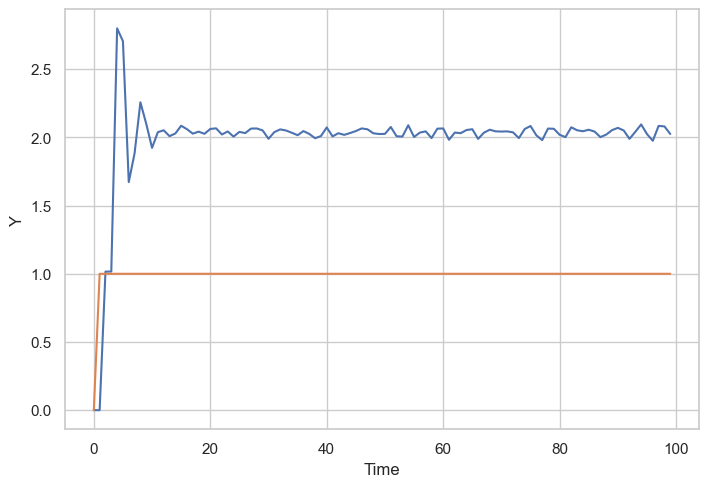

In [335]:
fig = plt.figure(figsize=(18,12))

plt.subplot(2, 2, 1)
plt.plot(data_frame[2000:])
plt.xlabel('Time')
plt.ylabel('Y')

In [336]:
display(data_frame.head(10))

,Y,U
0,1.211268,1.209331
1,1.194145,1.209331
2,2.991204,1.209331
3,2.621548,1.209331
4,1.884066,1.209331
5,2.041407,1.209331
6,2.327654,1.209331
7,2.175450,1.209331
8,2.060012,1.209331
9,2.159972,1.209331


In [337]:
# Batch size
batch_size = 100

batch_data = np.array_split(data_frame, int(data_frame.shape[0]/batch_size))
df = pd.DataFrame(np.concatenate(batch_data),columns=list(data_frame.columns))


/opt/anaconda3/envs/rnn4nds/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


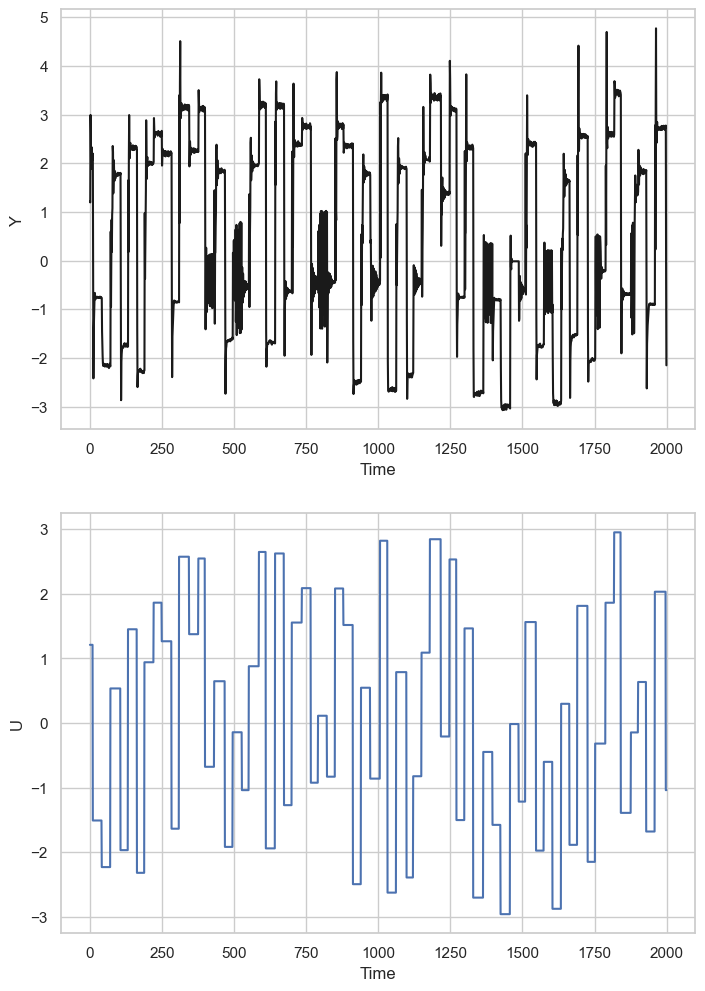

In [338]:
fig = plt.figure(figsize=(18,12))

batch_no_start = 1
batch_no_end = 20

plt.subplot(2, 2, 1)
plt.plot(data_frame[batch_size*(batch_no_start-1):batch_size*(batch_no_end)]['Y'],'k')
plt.xlabel('Time')
plt.ylabel('Y')

plt.subplot(2, 2, 3)
plt.plot(data_frame[batch_size*(batch_no_start-1):batch_size*(batch_no_end)]['U'],'b')
plt.xlabel('Time')
plt.ylabel('U')


plt.show()

In [339]:
ratio = 14 # how many samples from all of the data will be in training set
train_size = batch_size*ratio
dataset = df.values.astype(float)



print("before scaling: max value: ",dataset.max(),"min value: ",dataset.min())
dataset = dataset/max(dataset.max(),abs(dataset.min()))
print("after scaling: max value: ",dataset.max(),"min value: ",dataset.min())

# train_set = dataset[:train_size]
# test_set = dataset[train_size:]


train_set = dataset[:2000]
test_set = dataset[2000:]


train_set = torch.FloatTensor(train_set).view(-1,df.shape[1])
test_set = torch.FloatTensor(test_set).view(-1,df.shape[1])

train_set.shape

before scaling: max value:  4.770856726046943 min value:  -3.0744680235124937
after scaling: max value:  1.0 min value:  -0.644426818924816


torch.Size([2000, 2])

In [340]:
def input_data(seq,ws):
    inp_data = []
    for bat in range(0,train_set.shape[0],batch_size):
        
        bat_seq = seq[bat:bat+100]
        l = len(bat_seq)
        
        window = []
        label = []
        
        for i in range(l-ws):
        
            window = bat_seq[i:i+ws]
            label = bat_seq[i+ws:i+ws+1,:1]

            inp_data.append((window,label))
        
    return inp_data

In [341]:
# Defining a window size for prediction
window_size = 1
train_data = input_data(train_set,window_size)

print(train_data)

[(tensor([[0.2539, 0.2535]]), tensor([[0.2503]])), (tensor([[0.2503, 0.2535]]), tensor([[0.6270]])), (tensor([[0.6270, 0.2535]]), tensor([[0.5495]])), (tensor([[0.5495, 0.2535]]), tensor([[0.3949]])), (tensor([[0.3949, 0.2535]]), tensor([[0.4279]])), (tensor([[0.4279, 0.2535]]), tensor([[0.4879]])), (tensor([[0.4879, 0.2535]]), tensor([[0.4560]])), (tensor([[0.4560, 0.2535]]), tensor([[0.4318]])), (tensor([[0.4318, 0.2535]]), tensor([[0.4527]])), (tensor([[0.4527, 0.2535]]), tensor([[0.4605]])), (tensor([[ 0.4605, -0.3163]]), tensor([[-0.1176]])), (tensor([[-0.1176, -0.3163]]), tensor([[-0.5076]])), (tensor([[-0.5076, -0.3163]]), tensor([[-0.3090]])), (tensor([[-0.3090, -0.3163]]), tensor([[-0.2571]])), (tensor([[-0.2571, -0.3163]]), tensor([[-0.2070]])), (tensor([[-0.2070, -0.3163]]), tensor([[-0.1581]])), (tensor([[-0.1581, -0.3163]]), tensor([[-0.1395]])), (tensor([[-0.1395, -0.3163]]), tensor([[-0.1615]])), (tensor([[-0.1615, -0.3163]]), tensor([[-0.1673]])), (tensor([[-0.1673, -0.

In [342]:
from classy import LSTMModel

model = LSTMModel(2, 128, out_size=1, num_layers=4)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.00001)

In [343]:
display(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-05
    maximize: False
    weight_decay: 0
)

In [344]:
epochs = 100
batches = len(batch_data)*batch_size

average_loss = []
all_loss = []
show_logs_every_batch = False
hidden=model.init_hidden(batch_size=1)

for epoch in range(epochs):
    
    # Running each batch separately 
    
    for bat in range(0,batches,batch_size):

        for seq,label in train_data[bat:bat+batch_size]:
            
            # set the optimization gradient to zero

            optimizer.zero_grad()
            # Make predictions on the current sequence

            y_pred = model(seq, hidden)  
            
            # Compute the loss

            loss = criterion(y_pred, label)
            all_loss.append(loss.item())
            # Perform back propogation and gradient descent
            loss.backward()

            optimizer.step()
        
        model.init_hidden(1)
        average_loss.append(sum(all_loss)/len(all_loss))
        if (epoch+1)%10 == 0 and show_logs_every_batch:
            print(f'Epoch: {epoch+1}/{epochs}, batch: {bat+batch_size}/{batches}, Loss: {loss.item():10.8f}, Average Loss: {sum(all_loss)/len(all_loss)}')
            

                      


    if (epoch+1)%10 == 0 and not show_logs_every_batch:
        print(f'Epoch: {epoch+1}/{epochs} Loss: {loss.item():10.8f}, Average Loss: {sum(all_loss)/len(all_loss)}')

learnt_hidden=hidden

Epoch: 10/100 Loss: 0.12525834, Average Loss: 0.05203127985003639
Epoch: 20/100 Loss: 0.12400273, Average Loss: 0.03162172524034326
Epoch: 30/100 Loss: 0.12271474, Average Loss: 0.024698035088306307
Epoch: 40/100 Loss: 0.12189986, Average Loss: 0.02120577118128974
Epoch: 50/100 Loss: 0.12132197, Average Loss: 0.01910307844550269
Epoch: 60/100 Loss: 0.12086259, Average Loss: 0.017699352914862493
Epoch: 70/100 Loss: 0.12046593, Average Loss: 0.0166959751848028
Epoch: 80/100 Loss: 0.12010638, Average Loss: 0.015943028272679845
Epoch: 90/100 Loss: 0.11977269, Average Loss: 0.015357099905839363
Epoch: 100/100 Loss: 0.11946031, Average Loss: 0.014888118820282441


Text(0, 0.5, 'mse')

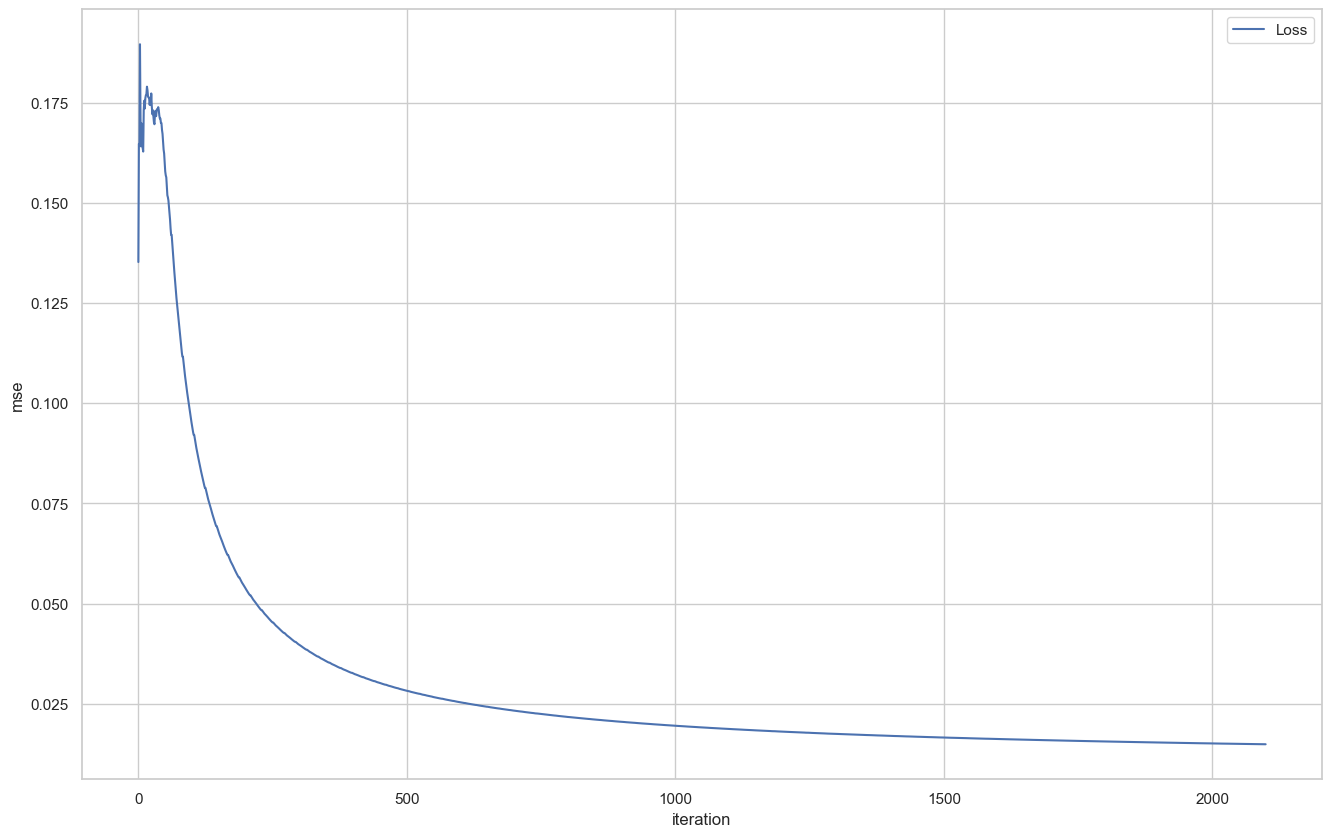

In [345]:
fig = plt.figure(figsize=(16,10))

plt.plot(average_loss,'b',label='Loss')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('mse')

In [346]:
dfmse = pd.DataFrame(average_loss)
dfmse.to_csv('mse.csv', index=False) 

In [347]:
future = 100

model.eval()
preds = [test_set[0,:1].reshape(-1,1)]

for i in range(future-1):
    seq = test_set[i].reshape(-1,2)
    with torch.no_grad():
        pred = model(seq, hidden)
        preds.append(pred)

        
print(len(preds))       

100


In [348]:
predictions = np.array([pred.numpy() for pred in preds]).reshape(-1,1)
true_values = np.array(test_set[:,:1])

Text(0, 0.5, 'x1')

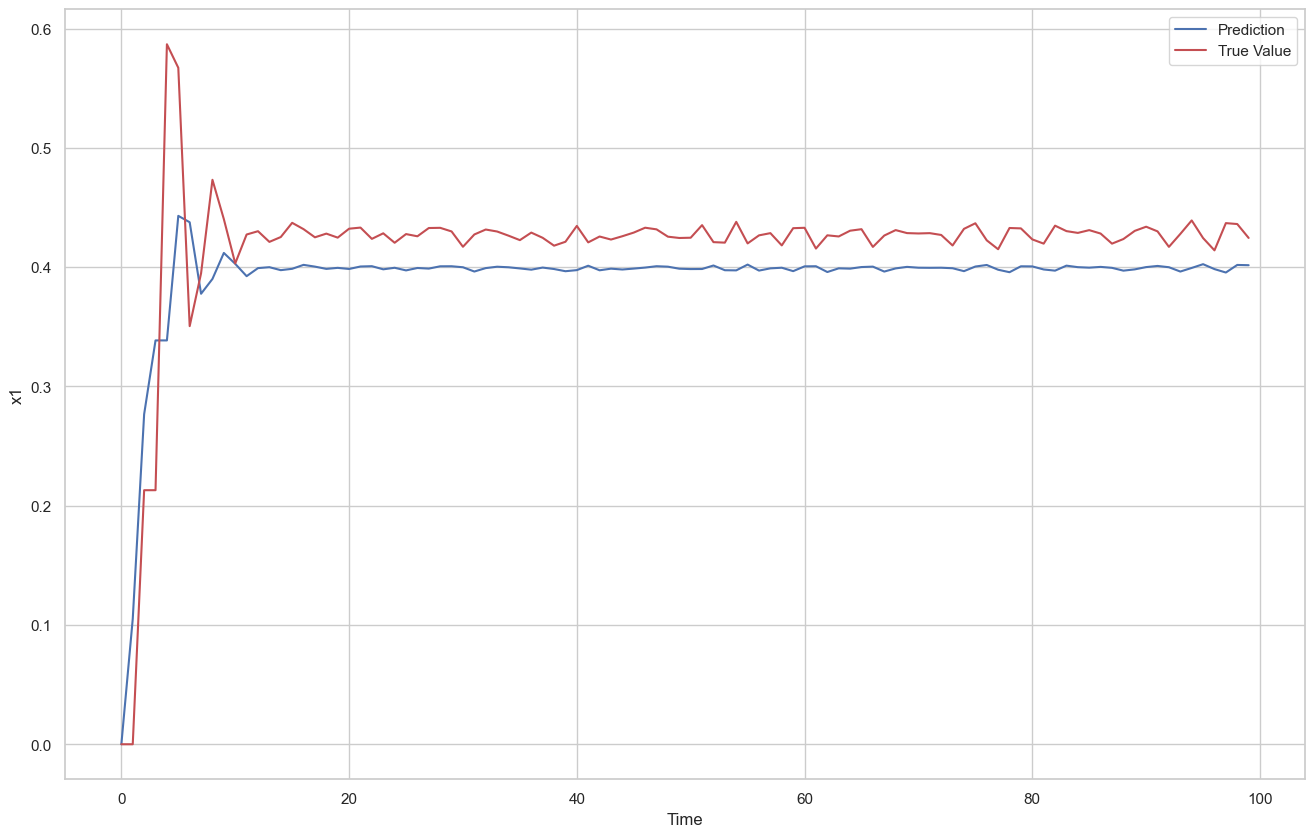

In [349]:
fig = plt.figure(figsize=(16,10))

plt.plot(predictions[:future,0],'b',label='Prediction')
plt.plot(true_values[:future,0],'r',label='True Value')
plt.legend()
plt.xlabel('Time')
plt.ylabel('x1')

In [350]:
rmse = np.sqrt(np.sum(np.square((predictions - true_values[:future])))/predictions.size)
display(rmse)

0.04440432244613243

In [351]:
future = 100
hidden = learnt_hidden
preds = [test_set[0,:1].reshape(-1,1)]
prediction_start = 1

for i in range(future-1):
    if i < prediction_start:
        seq = test_set[i].reshape(-1, 2)
    else:
        x = torch.FloatTensor(preds[-1])  # Assuming preds[-1] contains the last prediction
        y = test_set[i][1]
        seq = torch.FloatTensor([x, y]).view(-1, df.shape[1])
    # Check if the sequence length is greater than 0
    if seq.size(0) > 0:
        with torch.no_grad():
            pred = model(seq, hidden)
            preds.append(pred)

In [352]:
predictions2 = np.array([pred.numpy() for pred in preds]).reshape(-1,1)
true_values = np.array(test_set[:,:1])

Text(0, 0.5, 'x1')

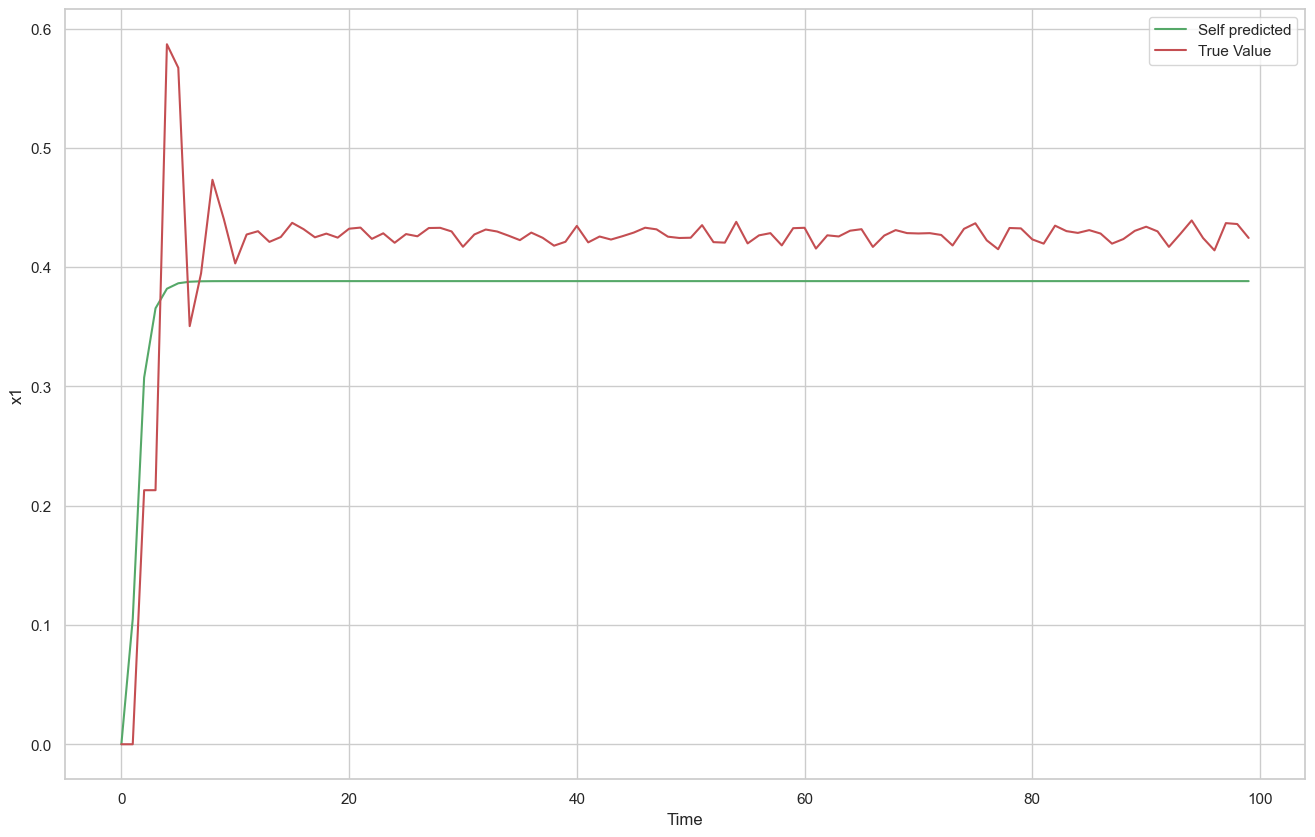

In [353]:
fig = plt.figure(figsize=(16,10))
plt.plot(predictions2[:future,0],'g',label='Self predicted')
# plt.plot(predictions[:future,0],'b',label='Prediction')
plt.plot(true_values[:future,0],'r',label='True Value')
plt.legend()
plt.xlabel('Time')
plt.ylabel('x1')

In [354]:
rmse = np.sqrt(np.sum(np.square((predictions2 - true_values[:future])))/predictions.size)
display(rmse)

0.05166916651471945

In [355]:
first_sample = test_set[:1]
remaining_samples = test_set[:-1]
is_like_sample_before = torch.cat((first_sample,remaining_samples),0)

### Porównanie - wykresy

Text(0, 0.5, 'x1')

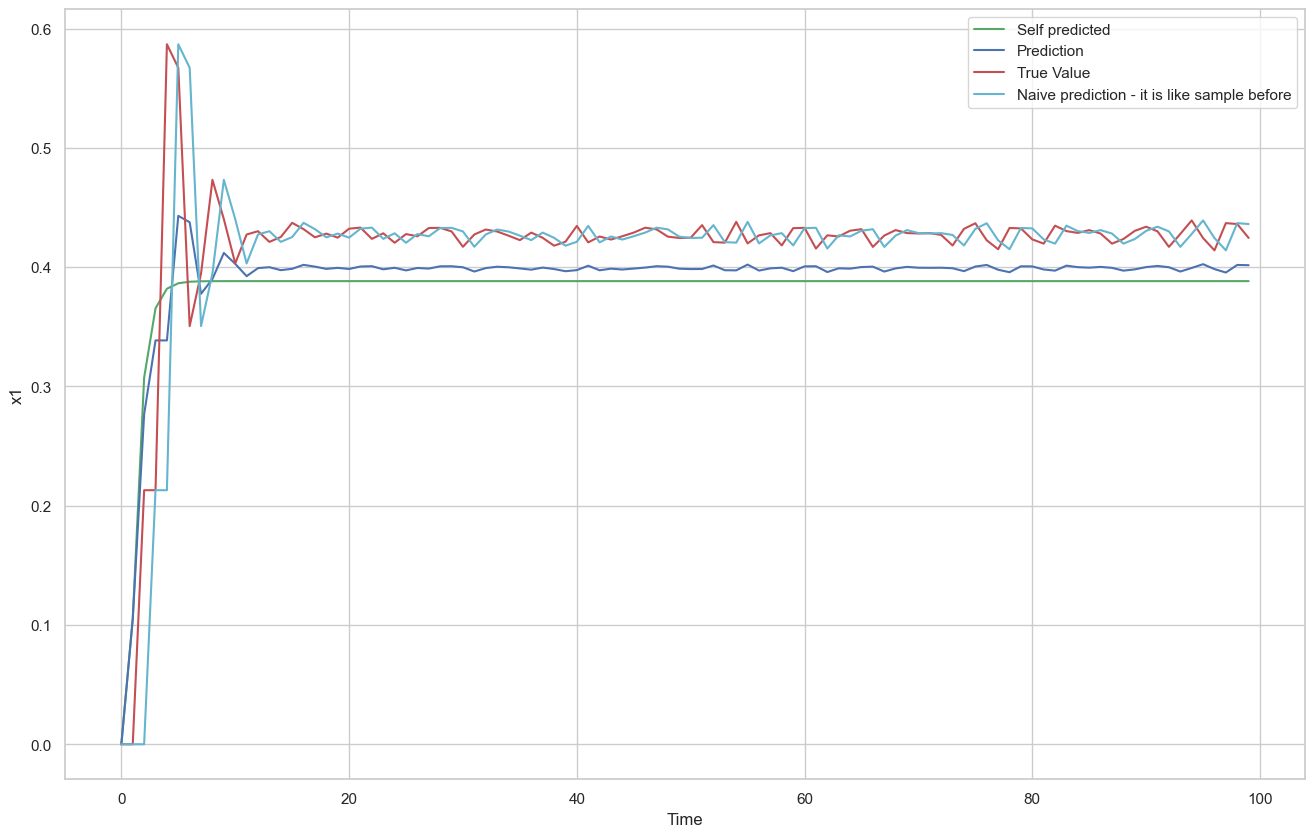

In [356]:
fig = plt.figure(figsize=(16,10))
plt.plot(predictions2[:future,0],'g',label='Self predicted')
plt.plot(predictions[:future,0],'b',label='Prediction')
plt.plot(true_values[:future,0],'r',label='True Value')
plt.plot(is_like_sample_before[:future,0],'c',label='Naive prediction - it is like sample before')
plt.legend()
plt.xlabel('Time')
plt.ylabel('x1')

In [357]:
dfmse = pd.DataFrame(list(predictions[:future,0]))
dfmse

dfmse.to_csv('systemresponse_one_ahead.csv', index=False) 

dfmse = pd.DataFrame(list(predictions2[:future,0]))
dfmse

dfmse.to_csv('systemresponse_alone.csv', index=False) 

### Porównanie RMSE

#### Przewidywanie naiwne

In [358]:
predictions3 = np.array(is_like_sample_before[:future,0].reshape(-1,1))
rmse = np.sqrt(np.sum(np.square((predictions3 - true_values[:future])))/predictions.size)
print(f"przewidywanie naiwne, rmse: {rmse:.4}")

przewidywanie naiwne, rmse: 0.05001


##### Przewidywanie próbki w przód

In [359]:
rmse = np.sqrt(np.sum(np.square((predictions - true_values[:future])))/predictions.size)
print(f"przewidywanie próbki w przód przy pomocy sieci lstm, rmse: {rmse:.4}")

przewidywanie próbki w przód przy pomocy sieci lstm, rmse: 0.0444


##### Test zastąpienia systemu - sieć nie jest karmiona danymi z rzeczywistego systemu

In [360]:
rmse = np.sqrt(np.sum(np.square((predictions2 - true_values[:future])))/predictions.size)
print(f"przewidywanie dla {future} próbek przy pomocy sieci lstm, rmse: {rmse:.4}")

przewidywanie dla 100 próbek przy pomocy sieci lstm, rmse: 0.05167


### Wnioski
